In [1]:
import os
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

train_path = 'C:/Users/zhang/mine/finTech/data/A/new/训练数据集'
test_path = 'C:/Users/zhang/mine/finTech/data/A/new/评分数据集'

train_tag_DF = pd.read_csv(train_path + '/训练数据集_tag.csv')
train_trd_DF = pd.read_csv(train_path + '/训练数据集_trd.csv')
train_beh_DF = pd.read_csv(train_path + '/训练数据集_beh.csv')

train_trd_DF.drop_duplicates(inplace = True)
train_beh_DF.drop_duplicates(inplace = True)
# 0: 违约
# 1: 诚信

In [2]:
train_tag_DF.drop(['edu_deg_cd', 'deg_cd', 'atdd_type',
                   #'dnl_mbl_bnk_ind', 'dnl_bind_cmb_lif_ind',
                   #'l12_mon_gld_buy_whl_tms', 'l12_mon_insu_buy_whl_tms', 
                   #'l6mon_agn_ind', #'bk1_cur_year_mon_avg_agn_amt_cd', 'ic_ind'
                  ], axis = 1, inplace = True)
train_tag_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39923 entries, 0 to 39922
Data columns (total 40 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   id                               39923 non-null  object
 1   flag                             39923 non-null  int64 
 2   gdr_cd                           39923 non-null  object
 3   age                              39923 non-null  int64 
 4   mrg_situ_cd                      39923 non-null  object
 5   acdm_deg_cd                      39922 non-null  object
 6   job_year                         39923 non-null  object
 7   ic_ind                           39923 non-null  object
 8   fr_or_sh_ind                     39923 non-null  object
 9   dnl_mbl_bnk_ind                  39923 non-null  object
 10  dnl_bind_cmb_lif_ind             39923 non-null  object
 11  hav_car_grp_ind                  39923 non-null  object
 12  hav_hou_grp_ind                 

In [3]:
#train_tag_DF.loc[train_tag_DF['cur_debit_min_opn_dt_cnt'] == -1, 'cur_debit_min_opn_dt_cnt'] = 0
#train_tag_DF.loc[train_tag_DF['cur_credit_min_opn_dt_cnt'] == -1, 'cur_credit_min_opn_dt_cnt'] = 0    
train_tag_DF.loc[train_tag_DF['job_year'] == '\\N', 'job_year'] = '-1'

strColName = ['gdr_cd', 'mrg_situ_cd', 'acdm_deg_cd']
colname = train_tag_DF.columns.values.tolist()
for col in colname[1:]:
    if col in strColName:
        train_tag_DF[col] = train_tag_DF[col].fillna('Unknown')
        train_tag_DF.loc[train_tag_DF[col] == '\\N', col] = 'Unknown'
        train_tag_DF.loc[train_tag_DF[col] == '~', col] = 'Unknown'
    if (not np.issubdtype(train_tag_DF[col], np.int64)):
        if ('0' in train_tag_DF[col].value_counts().index.tolist()) and ('-1' in train_tag_DF[col].value_counts().index.tolist()):
            train_tag_DF.loc[train_tag_DF[col] == '\\N', col] = '-2'
        elif ('0' in train_tag_DF[col].value_counts().index.tolist()):
            train_tag_DF.loc[train_tag_DF[col] == '\\N', col] = '-1'
        else:
            train_tag_DF.loc[train_tag_DF[col] == '\\N', col] = '0'

for col in colname[1:]:
    if (not np.issubdtype(train_tag_DF[col], np.int64)) and (col not in strColName):
        train_tag_DF[col] = train_tag_DF[col].astype(np.int64)
        

In [4]:
train_tag_DF['dnl_ind'] = train_tag_DF[['dnl_mbl_bnk_ind', 'dnl_bind_cmb_lif_ind']].apply(lambda x: x.sum(), axis = 1)
# 合并下载标志'dnl_mbl_bnk_ind', 'dnl_bind_cmb_lif_ind',
#train_tag_DF.drop(['dnl_mbl_bnk_ind', 'dnl_bind_cmb_lif_ind',], axis = 1, inplace = True)

train_tag_DF['I12_mon_whl_tms'] = train_tag_DF[['l12mon_buy_fin_mng_whl_tms',
                                                'l12_mon_fnd_buy_whl_tms',
                                                'l12_mon_insu_buy_whl_tms',
                                                'l12_mon_gld_buy_whl_tms']].apply(lambda x: x.fillna(0).astype(np.int).sum(), axis = 1).astype(np.int64)
# 理财产品、基金、保险、黄金购买次数总和


In [5]:
train_tag_DF['rsk_combine'] = train_tag_DF[['vld_rsk_ases_ind',
                                         'fin_rsk_ases_grd_cd',
                                         'confirm_rsk_ases_lvl_typ_cd',
                                         'cust_inv_rsk_endu_lvl_cd',
                                        ]].apply(lambda x: -abs(x[0]*x[1]*x[2]*x[3]) if any(x<0) else x[0]*x[1]*x[2]*x[3], axis = 1)



In [6]:
train_tag_DF['ast_combine'] = train_tag_DF[['tot_ast_lvl_cd',
                                         'pot_ast_lvl_cd',
                                        ]].apply(lambda x: -abs(x[0]*x[1]) if any(x<0) else x[0]*x[1], axis = 1)


In [7]:
train_tag_DF['rsk_mean'] = train_tag_DF[['vld_rsk_ases_ind',
                                         'fin_rsk_ases_grd_cd',
                                         'confirm_rsk_ases_lvl_typ_cd',
                                         'cust_inv_rsk_endu_lvl_cd',
                                        ]].apply(lambda x: x.mean(), axis = 1)

train_tag_DF['ast_mean'] = train_tag_DF[['tot_ast_lvl_cd',
                                         'pot_ast_lvl_cd',
                                        ]].apply(lambda x: x.mean(), axis = 1)


In [15]:
train_tag_DF.his_lng_ovd_day.value_counts()

 0       38853
-1         493
 1         151
 2          65
 3          36
         ...  
 880         1
 17          1
 113         1
 145         1
 1198        1
Name: his_lng_ovd_day, Length: 131, dtype: int64

In [8]:
train_tag_DF['cur_debit_card'] = train_tag_DF[['cur_debit_cnt', 
                                               'cur_debit_min_opn_dt_cnt', 
                                               'cur_debit_crd_lvl']].apply(lambda x: x[0] * x[1] * x[2] / 100, axis = 1)

train_tag_DF['cur_credit_card'] = train_tag_DF[[ 'cur_credit_cnt', 
                                                'cur_credit_min_opn_dt_cnt', 
                                                'hld_crd_card_grd_cd',
                                                'crd_card_act_ind']].apply(lambda x: x[0] * x[1] * (x[2] + 1e-5) * (x[3] + 1e-5), axis = 1)

train_tag_DF['ic_fr_sh_ind'] = train_tag_DF[['ic_ind', 'fr_or_sh_ind']].apply(lambda x: 4 if ((x[0] == 1) & (x[1] == 1)) else (3 if (x[1] == 1) else (2 if (x[0] == 1) else (1 if ((x[0] == 0) & (x[1] == 0)) else 0))), axis = 1)
# 0: no, 1: ic, 2: fr or sh, 3: both

train_tag_DF['hav_car_hou_ind'] = train_tag_DF[['hav_car_grp_ind',
                                                'hav_hou_grp_ind']].apply(lambda x: 4 if ((x[0] == 1) & (x[1] == 1)) else (3 if (x[1] == 1) else (2 if (x[0] == 1) else (1 if ((x[0] == 0) & (x[1] == 0)) else 0))), axis = 1)
# 0: no, 1: Car, 2: House, 3: both

train_tag_DF['ovd_cnt'] = train_tag_DF[['ovd_30d_loan_tot_cnt',
                                        'his_lng_ovd_day']].apply(lambda x: x[0] * x[1], axis = 1)

In [ ]:
tag_id_list = train_tag_DF.id.unique().tolist()
trd_id_list = train_trd_DF.id.unique().tolist()
beh_id_list = train_beh_DF.id.unique().tolist()

print('tag id个数: ', len(tag_id_list))
print('trd id个数: ', len(trd_id_list))
print('beh id个数: ', len(beh_id_list))

print('trd shape: {}, beh shape: {}'.format(train_trd_DF.shape[0], train_beh_DF.shape[0]))
print('trd里的id是否在tag用户标签: ', np.sum(train_trd_DF.id.isin(train_tag_DF.id)))
print('beh里的id是否在tag用户标签', np.sum(train_beh_DF.id.isin(train_tag_DF.id)))

# 跟trx表合并

In [9]:
trx_cod1_cd = train_trd_DF.groupby(['id', 'Trx_Cod1_Cd'])['trx_tm'].count()
trx_cod1_cd = trx_cod1_cd.reset_index()
trx_cod1_cd.rename(columns = {'trx_tm': 'trx_cod1_tms'}, inplace = True)
trx_cod1_cd.sort_values(['id', 'trx_cod1_tms'], inplace = True)

trx_cod1_cd.drop_duplicates('id', keep = 'last', inplace = True)
trx_cod1_cd.drop(['trx_cod1_tms'], axis = 1, inplace = True)
trx_cod1_cd.rename(columns = {'Trx_Cod1_Cd': 'most_Trx_Cod1_Cd'}, inplace = True)


trx_cod2_cd = train_trd_DF.groupby(['id', 'Trx_Cod2_Cd'])['trx_tm'].count()
trx_cod2_cd = trx_cod2_cd.reset_index()
trx_cod2_cd.rename(columns = {'trx_tm': 'trx_cod2_tms'}, inplace = True)
trx_cod2_cd.sort_values(['id', 'trx_cod2_tms'], inplace = True)

trx_cod2_cd.drop_duplicates('id', keep = 'last', inplace = True)
trx_cod2_cd.drop(['trx_cod2_tms'], axis = 1, inplace = True)
trx_cod2_cd.rename(columns = {'Trx_Cod2_Cd': 'most_Trx_Cod2_Cd'}, inplace = True)

train_DF = pd.merge(train_tag_DF, trx_cod1_cd, on = 'id', how = 'left')
train_DF = pd.merge(train_DF, trx_cod2_cd, on = 'id', how = 'left')

train_DF['most_Trx_Cod1_Cd'] = train_DF['most_Trx_Cod1_Cd'].fillna(0)
train_DF['most_Trx_Cod2_Cd'] = train_DF['most_Trx_Cod2_Cd'].fillna(0)
############ 支出、收入
id_pay = train_trd_DF.groupby(['id', 'Dat_Flg1_Cd'])['cny_trx_amt'].sum().reset_index()

id_income = id_pay[id_pay['Dat_Flg1_Cd'] == 'C']
id_pay = id_pay[id_pay['Dat_Flg1_Cd'] == 'B']

id_income.reset_index(drop = True, inplace = True)
id_pay.reset_index(drop = True, inplace = True)

id_income.drop(['Dat_Flg1_Cd'], axis = 1, inplace = True)
id_pay.drop(['Dat_Flg1_Cd'], axis = 1, inplace = True)

id_income.rename(columns = {'cny_trx_amt': 'cny_trx_income'}, inplace = True)
id_pay.rename(columns = {'cny_trx_amt': 'cny_trx_pay'}, inplace = True)

id_income['cny_trx_income'] = id_income['cny_trx_income'].abs()
id_pay['cny_trx_pay'] = id_pay['cny_trx_pay'].abs()

train_DF = pd.merge(train_DF, id_income, on = 'id', how = 'left')
train_DF = pd.merge(train_DF, id_pay, on = 'id', how = 'left')

train_DF['cny_trx_income'] = train_DF['cny_trx_income'].fillna(0)
train_DF['cny_trx_pay'] = train_DF['cny_trx_pay'].fillna(0)
train_DF['actual_income'] = train_DF[['cny_trx_income', 'cny_trx_pay']].apply(lambda x: x[0] - x[1], axis = 1)
#train_DF['actual_income_rate'] = train_DF[['cny_trx_income', 'actual_income']].apply(lambda x: x[1]/x[0] if (x[0] > 0) else x[1], axis = 1)

###
# 交易方式
trx_way = train_trd_DF.groupby(['id', 'Dat_Flg3_Cd'])['trx_tm'].count()
trx_way = trx_way.reset_index()
trx_way.rename(columns = {'trx_tm': 'trx_way_tms'}, inplace = True)
trx_way.sort_values(['id', 'trx_way_tms'], inplace = True)

trx_way.drop_duplicates('id', keep = 'last', inplace = True)
trx_way.drop(['trx_way_tms'], axis = 1, inplace = True)
trx_way.rename(columns = {'Dat_Flg3_Cd': 'most_trx_way'}, inplace = True)
train_DF = pd.merge(train_DF, trx_way, on = 'id', how = 'left')
train_DF['most_trx_way'] = train_DF['most_trx_way'].fillna('Undo')

# 交易次数
trx_tms = train_trd_DF.groupby(['id'])['trx_tm'].count()
trx_tms = trx_tms.reset_index()
trx_tms.rename(columns = {'trx_tm': 'trx_tms'}, inplace = True)
train_DF = pd.merge(train_DF, trx_tms, on = 'id', how = 'left')
train_DF['trx_tms'] = train_DF['trx_tms'].fillna(0)

trx_Dat_Flg1_Cd_cnt = pd.crosstab(train_trd_DF['id'],train_trd_DF['Dat_Flg1_Cd'])
trx_Dat_Flg1_Cd_cnt = trx_Dat_Flg1_Cd_cnt.reset_index()
temp_columns = trx_Dat_Flg1_Cd_cnt.columns.tolist()
for col in temp_columns[1:]:
    trx_Dat_Flg1_Cd_cnt.rename(columns = {col: 'Dat_Flg1_Cd_' + col}, inplace = True)
train_DF = pd.merge(train_DF, trx_Dat_Flg1_Cd_cnt, on = 'id', how = 'left')

temp_columns = trx_Dat_Flg1_Cd_cnt.columns.tolist()
for col in temp_columns[1:]:
    train_DF[col] = train_DF[col].fillna(0)

trx_Dat_Flg3_Cd_cnt = pd.crosstab(train_trd_DF['id'],train_trd_DF['Dat_Flg3_Cd'])
trx_Dat_Flg3_Cd_cnt = trx_Dat_Flg3_Cd_cnt.reset_index()
temp_columns = trx_Dat_Flg3_Cd_cnt.columns.tolist()
for col in temp_columns[1:]:
    trx_Dat_Flg3_Cd_cnt.rename(columns = {col: 'Dat_Flg3_Cd_' + col}, inplace = True)
train_DF = pd.merge(train_DF, trx_Dat_Flg3_Cd_cnt, on = 'id', how = 'left')

temp_columns = trx_Dat_Flg3_Cd_cnt.columns.tolist()
for col in temp_columns[1:]:
    train_DF[col] = train_DF[col].fillna(0)
train_DF.head()

,id,flag,gdr_cd,age,mrg_situ_cd,acdm_deg_cd,job_year,ic_ind,fr_or_sh_ind,dnl_mbl_bnk_ind,dnl_bind_cmb_lif_ind,hav_car_grp_ind,hav_hou_grp_ind,l6mon_agn_ind,frs_agn_dt_cnt,vld_rsk_ases_ind,fin_rsk_ases_grd_cd,confirm_rsk_ases_lvl_typ_cd,cust_inv_rsk_endu_lvl_cd,l6mon_daim_aum_cd,tot_ast_lvl_cd,pot_ast_lvl_cd,bk1_cur_year_mon_avg_agn_amt_cd,l12mon_buy_fin_mng_whl_tms,l12_mon_fnd_buy_whl_tms,l12_mon_insu_buy_whl_tms,l12_mon_gld_buy_whl_tms,loan_act_ind,pl_crd_lmt_cd,ovd_30d_loan_tot_cnt,his_lng_ovd_day,hld_crd_card_grd_cd,crd_card_act_ind,l1y_crd_card_csm_amt_dlm_cd,perm_crd_lmt_cd,cur_debit_cnt,cur_credit_cnt,cur_debit_min_opn_dt_cnt,cur_credit_min_opn_dt_cnt,cur_debit_crd_lvl,dnl_ind,I12_mon_whl_tms,rsk_combine,ast_combine,rsk_mean,ast_mean,cur_debit_card,cur_credit_card,ic_fr_sh_ind,hav_car_hou_ind,ovd_cnt,most_Trx_Cod1_Cd,most_Trx_Cod2_Cd,cny_trx_income,cny_trx_pay,actual_income,most_trx_way,trx_tms,Dat_Flg1_Cd_B,Dat_Flg1_Cd_C,Dat_Flg3_Cd_A,Dat_Flg3_Cd_B,Dat_Flg3_Cd_C
0,U7A4BAD,0,M,41,B,Z,3,0,0,0,1,0,0,0,-1,0,-1,4,1,0,-1,6,0,0,0,0,0,0,0,0,0,-1,0,0,3,1,0,3492,-1,10,1,0,0,-6,1.00,2.5,349.2,-0.0,1,1,0,2.0,208.0,17400.00,15000.00,2400.00,C,3.0,1.0,2.0,0.0,0.0,3.0
1,U557810,0,M,35,A,G,4,0,0,0,0,0,0,0,-1,0,-1,-1,1,0,-1,-1,0,0,0,0,0,0,0,0,0,-1,0,0,1,1,0,4575,-1,10,0,0,0,-1,-0.25,-1.0,457.5,-0.0,1,1,0,0.0,0.0,0.00,0.00,0.00,Undo,0.0,0.0,0.0,0.0,0.0,0.0
2,U1E9240,0,M,53,B,C,9,0,0,1,1,0,0,1,935,1,3,3,6,7,-1,2,8,6,0,0,0,0,0,0,0,-1,0,0,7,2,0,4894,-1,40,2,6,54,-2,3.25,0.5,3915.2,-0.0,1,1,0,2.0,208.0,105718.04,131158.00,-25439.96,A,17.0,6.0,11.0,17.0,0.0,0.0
3,U6DED00,0,F,41,B,Z,0,0,0,0,0,0,0,0,-1,0,-1,-1,1,0,-1,6,0,0,0,0,0,0,0,0,0,-1,0,0,1,1,0,4938,-1,10,0,0,0,-6,-0.25,2.5,493.8,-0.0,1,1,0,0.0,0.0,0.00,0.00,0.00,Undo,0.0,0.0,0.0,0.0,0.0,0.0
4,UDA8E28,0,F,42,B,Z,3,1,1,1,0,0,1,0,-1,0,-1,-1,1,5,-1,3,0,0,0,0,0,1,6,0,4,-1,0,0,2,7,0,2378,-1,20,1,0,0,-3,-0.25,1.0,3329.2,-0.0,4,3,0,2.0,308.0,79505.55,70416.04,9089.51,A,18.0,5.0,13.0,18.0,0.0,0.0


# 结合app行为表beh

In [10]:
beh_page_no_cnt = pd.crosstab(train_trd_DF['id'],train_beh_DF['page_no'])
beh_page_no_cnt = beh_page_no_cnt.reset_index()
page_no_columns = beh_page_no_cnt.columns.tolist()
for col in page_no_columns[1:]:
    beh_page_no_cnt.rename(columns = {col: 'beh_page_no_' + col}, inplace = True)
train_DF = pd.merge(train_DF, beh_page_no_cnt, on = 'id', how = 'left')
page_no_columns = beh_page_no_cnt.columns.tolist()
for col in page_no_columns[1:]:
    train_DF[col] = train_DF[col].fillna(0)

    
id_beh = train_beh_DF.groupby(['id', 'page_no'])['page_tm'].count()
id_beh = id_beh.reset_index()
id_beh.rename(columns = {'page_tm': 'page_tms'}, inplace = True)
id_beh.sort_values(['id', 'page_tms'], inplace = True)

id_beh_class_count = id_beh.groupby(['id']).count()
id_beh_class_count = id_beh_class_count.reset_index()
id_beh_class_count.head(10)

id_beh_class_count.drop(['page_tms'], axis = 1, inplace = True)
id_beh_class_count.rename(columns = {'page_no': 'page_type_count'}, inplace = True)
id_beh_class_count.head(10)

id_beh.drop_duplicates('id', keep = 'last', inplace = True)
id_beh.drop(['page_tms'], axis = 1, inplace = True)
id_beh.rename(columns = {'page_no': 'most_tms_page_no'}, inplace = True)


beh_count = train_beh_DF.groupby(['id'])['page_tm'].count()
beh_count = beh_count.reset_index()
beh_count.rename(columns = {'page_tm': 'total_page_no_tms'}, inplace = True)

train_DF = pd.merge(train_DF, id_beh_class_count, on = 'id', how = 'left')
train_DF = pd.merge(train_DF, id_beh, on = 'id', how = 'left')
train_DF = pd.merge(train_DF, beh_count, on = 'id', how = 'left')

train_DF[['total_page_no_tms', 'page_type_count']] = train_DF[['total_page_no_tms', 'page_type_count']].fillna(0)
train_DF[['total_page_no_tms', 'page_type_count']] = train_DF[['total_page_no_tms', 'page_type_count']].astype(np.int64)

train_DF['most_tms_page_no'] = train_DF['most_tms_page_no'].fillna('Undo')
train_DF.head()

,id,flag,gdr_cd,age,mrg_situ_cd,acdm_deg_cd,job_year,ic_ind,fr_or_sh_ind,dnl_mbl_bnk_ind,dnl_bind_cmb_lif_ind,hav_car_grp_ind,hav_hou_grp_ind,l6mon_agn_ind,frs_agn_dt_cnt,vld_rsk_ases_ind,fin_rsk_ases_grd_cd,confirm_rsk_ases_lvl_typ_cd,cust_inv_rsk_endu_lvl_cd,l6mon_daim_aum_cd,tot_ast_lvl_cd,pot_ast_lvl_cd,bk1_cur_year_mon_avg_agn_amt_cd,l12mon_buy_fin_mng_whl_tms,l12_mon_fnd_buy_whl_tms,l12_mon_insu_buy_whl_tms,l12_mon_gld_buy_whl_tms,loan_act_ind,pl_crd_lmt_cd,ovd_30d_loan_tot_cnt,his_lng_ovd_day,hld_crd_card_grd_cd,crd_card_act_ind,l1y_crd_card_csm_amt_dlm_cd,perm_crd_lmt_cd,cur_debit_cnt,cur_credit_cnt,cur_debit_min_opn_dt_cnt,cur_credit_min_opn_dt_cnt,cur_debit_crd_lvl,dnl_ind,I12_mon_whl_tms,rsk_combine,ast_combine,rsk_mean,ast_mean,cur_debit_card,cur_credit_card,ic_fr_sh_ind,hav_car_hou_ind,ovd_cnt,most_Trx_Cod1_Cd,most_Trx_Cod2_Cd,cny_trx_income,cny_trx_pay,actual_income,most_trx_way,trx_tms,Dat_Flg1_Cd_B,Dat_Flg1_Cd_C,Dat_Flg3_Cd_A,Dat_Flg3_Cd_B,Dat_Flg3_Cd_C,beh_page_no_AAO,beh_page_no_BWA,beh_page_no_BWE,beh_page_no_CQA,beh_page_no_CQB,beh_page_no_CQC,beh_page_no_CQD,beh_page_no_CQE,beh_page_no_CTR,beh_page_no_EGA,beh_page_no_EGB,beh_page_no_FDA,beh_page_no_FLS,beh_page_no_FTR,beh_page_no_GBA,beh_page_no_JF2,beh_page_no_JJD,beh_page_no_JJK,beh_page_no_LC0,beh_page_no_LCT,beh_page_no_MSG,beh_page_no_MTA,beh_page_no_SYK,beh_page_no_SZA,beh_page_no_SZD,beh_page_no_TRN,beh_page_no_XAG,beh_page_no_XAI,beh_page_no_ZY1,page_type_count,most_tms_page_no,total_page_no_tms
0,U7A4BAD,0,M,41,B,Z,3,0,0,0,1,0,0,0,-1,0,-1,4,1,0,-1,6,0,0,0,0,0,0,0,0,0,-1,0,0,3,1,0,3492,-1,10,1,0,0,-6,1.00,2.5,349.2,-0.0,1,1,0,2.0,208.0,17400.00,15000.00,2400.00,C,3.0,1.0,2.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0,Undo,0
1,U557810,0,M,35,A,G,4,0,0,0,0,0,0,0,-1,0,-1,-1,1,0,-1,-1,0,0,0,0,0,0,0,0,0,-1,0,0,1,1,0,4575,-1,10,0,0,0,-1,-0.25,-1.0,457.5,-0.0,1,1,0,0.0,0.0,0.00,0.00,0.00,Undo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Undo,0
2,U1E9240,0,M,53,B,C,9,0,0,1,1,0,0,1,935,1,3,3,6,7,-1,2,8,6,0,0,0,0,0,0,0,-1,0,0,7,2,0,4894,-1,40,2,6,54,-2,3.25,0.5,3915.2,-0.0,1,1,0,2.0,208.0,105718.04,131158.00,-25439.96,A,17.0,6.0,11.0,17.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0,6,TRN,0
3,U6DED00,0,F,41,B,Z,0,0,0,0,0,0,0,0,-1,0,-1,-1,1,0,-1,6,0,0,0,0,0,0,0,0,0,-1,0,0,1,1,0,4938,-1,10,0,0,0,-6,-0.25,2.5,493.8,-0.0,1,1,0,0.0,0.0,0.00,0.00,0.00,Undo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Undo,0
4,UDA8E28,0,F,42,B,Z,3,1,1,1,0,0,1,0,-1,0,-1,-1,1,5,-1,3,0,0,0,0,0,1,6,0,4,-1,0,0,2,7,0,2378,-1,20,1,0,0,-3,-0.25,1.0,3329.2,-0.0,4,3,0,2.0,308.0,79505.55,70416.04,9089.51,A,18.0,5.0,13.0,18.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,7,TRN,0


In [ ]:
'vld_rsk_ases_ind',
                                 'total_page_no_tms',
                                 'rsk_combine',
                                 'ovd_30d_loan_tot_cnt',
                                 'l6mon_agn_ind',
                                 'l12_mon_insu_buy_whl_tms',
                                 'l12_mon_gld_buy_whl_tms',
                                 'ic_ind',
                                 'ic_fr_sh_ind',
                                 'hav_hou_grp_ind',
                                 'fin_rsk_ases_grd_cd',
                                 #'dnl_mbl_bnk_ind',
                                 'cur_debit_crd_lvl',
                                 'crd_card_act_ind',
                                 'bk1_cur_year_mon_avg_agn_amt_cd',
                                 'beh_page_no_ZY1',
                                 'beh_page_no_XAG',
                                 'beh_page_no_TRN',
                                 'beh_page_no_SZD',
                                 'beh_page_no_SZA',
                                 'beh_page_no_SYK',
                                 'beh_page_no_MTA',
                                 'beh_page_no_MSG',
                                 'beh_page_no_LCT',
                                 'beh_page_no_JJK',
                                 'beh_page_no_JJD',
                                 'beh_page_no_GBA',
                                 'beh_page_no_FLS',
                                 'beh_page_no_FDA',
                                 'beh_page_no_EGB',
                                 'beh_page_no_CQE',
                                 'beh_page_no_CQC',

# 尝试预测

In [17]:
#train_DF_weneed = train_DF.drop(['id', 'cny_trx_pay', 'cny_trx_income'], axis = 1)
train_DF_weneed = train_DF.drop(['id',
                                 'I12_mon_whl_tms',
                                 'l12mon_buy_fin_mng_whl_tms',
                                 #'beh_page_no_XAI', # remain
                                 'cur_debit_cnt',
                                 'beh_page_no_SZA',
                                 'ast_mean',
                                 'cur_debit_card',
                                 'Dat_Flg3_Cd_C',
                                 'beh_page_no_CQB', # 持平 20+
                                 'tot_ast_lvl_cd',
                                 'vld_rsk_ases_ind', # 持平 30+
                                 'total_page_no_tms', # 持平 30+
                                 'ovd_30d_loan_tot_cnt',  # 持平 20+
                                 #'mrg_situ_cd',  # remain
                                 'l6mon_agn_ind', # 持平 30+
                                 'l12_mon_insu_buy_whl_tms', # 持平 30+
                                 'l12_mon_gld_buy_whl_tms', # 持平 30+
                                 'ic_ind', # 持平 30+
                                 'ic_fr_sh_ind', # 持平 30+
                                 'hav_hou_grp_ind', # 持平
                                 'cur_debit_crd_lvl',
                                 'crd_card_act_ind', # 持平
                                 'bk1_cur_year_mon_avg_agn_amt_cd',
                                 'beh_page_no_ZY1', # 持平
                                 'beh_page_no_XAG',
                                 'beh_page_no_TRN',
                                 'beh_page_no_SZD', # 持平
                                 'beh_page_no_SYK', # 持平
                                 'beh_page_no_MTA', # 持平
                                 'beh_page_no_LCT', # 持平
                                 'beh_page_no_LC0', # 持平
                                 'beh_page_no_JJK', # 持平
                                 'beh_page_no_JJD', # 持平
                                 'beh_page_no_GBA', # 持平
                                 'beh_page_no_FLS', # 持平
                                 'beh_page_no_FDA', # 持平
                                 'beh_page_no_EGB', # 持平
                                 'beh_page_no_EGA', # 持平
                                 #'beh_page_no_CTR',  # remain # 持平
                                 #'beh_page_no_CQE', # remain # 持平
                                 'beh_page_no_CQC', # 持平
                                 'beh_page_no_BWE', # 持平
                                 'beh_page_no_BWA', # 持平
                                 
                                ],
                                axis = 1)
#train_DF_weneed = train_DF.drop(['id'], axis = 1)
train_DF_weneed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39923 entries, 0 to 39922
Data columns (total 55 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   flag                         39923 non-null  int64  
 1   gdr_cd                       39923 non-null  object 
 2   age                          39923 non-null  int64  
 3   mrg_situ_cd                  39923 non-null  object 
 4   acdm_deg_cd                  39923 non-null  object 
 5   job_year                     39923 non-null  int64  
 6   fr_or_sh_ind                 39923 non-null  int64  
 7   dnl_mbl_bnk_ind              39923 non-null  int64  
 8   dnl_bind_cmb_lif_ind         39923 non-null  int64  
 9   hav_car_grp_ind              39923 non-null  int64  
 10  frs_agn_dt_cnt               39923 non-null  int64  
 11  fin_rsk_ases_grd_cd          39923 non-null  int64  
 12  confirm_rsk_ases_lvl_typ_cd  39923 non-null  int64  
 13  cust_inv_rsk_end

In [18]:
strCol2 = []
for col in train_DF_weneed.columns.values.tolist():
    if (not np.issubdtype(train_DF_weneed[col], np.int64)) and (not np.issubdtype(train_DF_weneed[col], np.float64)):
        strCol2.append(col)
        
strCol2

['gdr_cd', 'mrg_situ_cd', 'acdm_deg_cd', 'most_trx_way', 'most_tms_page_no']

In [19]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
encoderLabel = LabelEncoder()

for sC in strCol2:
    train_DF_weneed[sC] = encoderLabel.fit_transform(train_DF_weneed[sC])

train_DF_weneed.head()

,flag,gdr_cd,age,mrg_situ_cd,acdm_deg_cd,job_year,fr_or_sh_ind,dnl_mbl_bnk_ind,dnl_bind_cmb_lif_ind,hav_car_grp_ind,frs_agn_dt_cnt,fin_rsk_ases_grd_cd,confirm_rsk_ases_lvl_typ_cd,cust_inv_rsk_endu_lvl_cd,l6mon_daim_aum_cd,pot_ast_lvl_cd,l12_mon_fnd_buy_whl_tms,loan_act_ind,pl_crd_lmt_cd,his_lng_ovd_day,hld_crd_card_grd_cd,l1y_crd_card_csm_amt_dlm_cd,perm_crd_lmt_cd,cur_credit_cnt,cur_debit_min_opn_dt_cnt,cur_credit_min_opn_dt_cnt,dnl_ind,rsk_combine,ast_combine,rsk_mean,cur_credit_card,hav_car_hou_ind,ovd_cnt,most_Trx_Cod1_Cd,most_Trx_Cod2_Cd,cny_trx_income,cny_trx_pay,actual_income,most_trx_way,trx_tms,Dat_Flg1_Cd_B,Dat_Flg1_Cd_C,Dat_Flg3_Cd_A,Dat_Flg3_Cd_B,beh_page_no_AAO,beh_page_no_CQA,beh_page_no_CQD,beh_page_no_CQE,beh_page_no_CTR,beh_page_no_FTR,beh_page_no_JF2,beh_page_no_MSG,beh_page_no_XAI,page_type_count,most_tms_page_no
0,0,1,41,1,7,3,0,0,1,0,-1,-1,4,1,0,6,0,0,0,0,-1,0,3,0,3492,-1,1,0,-6,1.00,-0.0,1,0,2.0,208.0,17400.00,15000.00,2400.00,2,3.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0,21
1,0,1,35,0,5,4,0,0,0,0,-1,-1,-1,1,0,-1,0,0,0,0,-1,0,1,0,4575,-1,0,0,-1,-0.25,-0.0,1,0,0.0,0.0,0.00,0.00,0.00,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,21
2,0,1,53,1,2,9,0,1,1,0,935,3,3,6,7,2,0,0,0,0,-1,0,7,0,4894,-1,2,54,-2,3.25,-0.0,1,0,2.0,208.0,105718.04,131158.00,-25439.96,0,17.0,6.0,11.0,17.0,0.0,0.0,3.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,6,20
3,0,0,41,1,7,0,0,0,0,0,-1,-1,-1,1,0,6,0,0,0,0,-1,0,1,0,4938,-1,0,0,-6,-0.25,-0.0,1,0,0.0,0.0,0.00,0.00,0.00,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,21
4,0,0,42,1,7,3,1,1,0,0,-1,-1,-1,1,5,3,0,1,6,4,-1,0,2,0,2378,-1,1,0,-3,-0.25,-0.0,3,0,2.0,308.0,79505.55,70416.04,9089.51,0,18.0,5.0,13.0,18.0,0.0,0.0,6.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,7,20


roc  0.7539872326799791
accuracy score is: 0.8117720726361929
precision score is: 0.6638888888888889
recall score is: 0.2748706152961472
auc: 0.7539872326799791
- - - - - - 


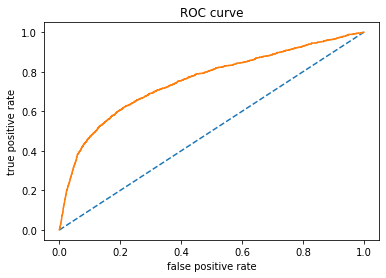

In [20]:
#train_DF_weneed.reindex(columns = ['flag'] + xgb_feature_list)
df_x = train_DF_weneed.drop(['flag'], axis = 1)
df_y = train_DF_weneed['flag']
trainx, valx, trainy, valy = train_test_split(df_x, df_y, test_size=.2, random_state=2020)

# 分层k折交叉拆分器 - 用于网格搜索
cv = StratifiedKFold(n_splits=10, shuffle=True)

####### 
# 删XGB重要变量,不删'mrg_situ_cd', 'ovd_30d_loan_tot_cnt'
# new data
# tag: 丢'edu_deg_cd', 'deg_cd', 'atdd_type',
# ~跟\N都填充unknown
# job_year 填-1
#      合并四个交易的次数,
#      合并Car hou， ic fsind
#       加ovd_30d_loan_tot_cnt, his_lng_ovd_day组合
# 合并下载标志'dnl_mbl_bnk_ind', 'dnl_bind_cmb_lif_ind'
# 加风险等级的合并
# trx: 支付一级、二级最高次数代码，支出、收入、以及净收入（或净支出），总操作次数,各类代码
# 不加beh: 操作总次数、操作最高频页面代码,各类代码
################# XGBoost
xgb_cfl = xgb.XGBClassifier(n_jobs = -1,
                            n_estimators = 50,
                            class_weight = 'balanced',
                            max_depth = 3)

xgb_cfl.fit(trainx, trainy)
y_scorexgb = xgb_cfl.predict_proba(valx)[:,1]

rocxgb=roc_auc_score(valy, y_scorexgb)
print('roc ',rocxgb)
perfomance_clf(xgb_cfl, valx, valy)

plot_roc(valy, y_scorexgb)
# 0.7539641241584953
# 0.7539872326799791

roc  0.7511845188741381
accuracy score is: 0.8100187852222918
precision score is: 0.6533149171270718
recall score is: 0.2719953996549741
auc: 0.7511845188741381
- - - - - - 


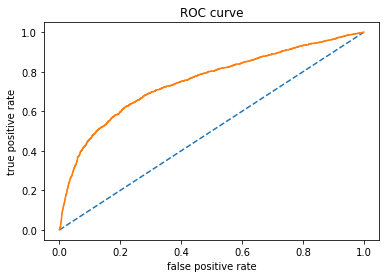

In [33]:
#train_DF_weneed.reindex(columns = ['flag'] + xgb_feature_list)
df_x = train_DF_weneed.drop(['flag'], axis = 1)
df_y = train_DF_weneed['flag']
trainx, valx, trainy, valy = train_test_split(df_x, df_y, test_size=.2, random_state=2020)

# 分层k折交叉拆分器 - 用于网格搜索
cv = StratifiedKFold(n_splits=10, shuffle=True)

####### 
# 删XGB重要变量,不删'mrg_situ_cd', 'ovd_30d_loan_tot_cnt'
# new data
# tag: 丢'edu_deg_cd', 'deg_cd', 'atdd_type',
# ~跟\N都填充unknown
# job_year 填-1
#      合并四个交易的次数,
#      合并Car hou， ic fsind
#       加ovd_30d_loan_tot_cnt, his_lng_ovd_day组合
# 合并下载标志'dnl_mbl_bnk_ind', 'dnl_bind_cmb_lif_ind'
# 加风险等级的合并
# trx: 支付一级、二级最高次数代码，支出、收入、以及净收入（或净支出），总操作次数,各类代码
# 不加beh: 操作总次数、操作最高频页面代码,各类代码
################# XGBoost
xgb_cfl = xgb.XGBClassifier(n_jobs = -1,
                            n_estimators = 50,
                            class_weight = 'balanced',
                            max_depth = 3)

xgb_cfl.fit(trainx, trainy)
y_scorexgb = xgb_cfl.predict_proba(valx)[:,1]

rocxgb=roc_auc_score(valy, y_scorexgb)
print('roc ',rocxgb)
perfomance_clf(xgb_cfl, valx, valy)

plot_roc(valy, y_scorexgb)
# 0.7539641241584953
# 0.7539872326799791

In [15]:

train_x = train_DF_weneed.drop(['flag'], axis = 1)
train_y = train_DF_weneed.flag
colname = train_x.columns.values.tolist()

import xgboost as xgb
xgb_cfl = xgb.XGBClassifier(n_jobs = -1,
                            n_estimators = 50,
                            class_weight = 'balanced',
                            max_depth = 3)

xgb_cfl.fit(train_x, train_y)
xgb_feature = sorted(zip(map(lambda x: round(x, 4), xgb_cfl.feature_importances_), colname),  reverse=True)
xgb_feature

[(0.0939, 'l1y_crd_card_csm_amt_dlm_cd'),
 (0.0794, 'dnl_ind'),
 (0.0634, 'cny_trx_income'),
 (0.0555, 'most_Trx_Cod2_Cd'),
 (0.0436, 'gdr_cd'),
 (0.0429, 'most_Trx_Cod1_Cd'),
 (0.0374, 'acdm_deg_cd'),
 (0.0357, 'cny_trx_pay'),
 (0.0356, 'ovd_cnt'),
 (0.0354, 'most_trx_way'),
 (0.031, 'fr_or_sh_ind'),
 (0.0305, 'Dat_Flg1_Cd_C'),
 (0.0229, 'hav_car_grp_ind'),
 (0.0224, 'dnl_bind_cmb_lif_ind'),
 (0.022, 'l6mon_daim_aum_cd'),
 (0.0184, 'pot_ast_lvl_cd'),
 (0.0182, 'cur_credit_min_opn_dt_cnt'),
 (0.0173, 'Dat_Flg3_Cd_B'),
 (0.0123, 'hld_crd_card_grd_cd'),
 (0.0123, 'his_lng_ovd_day'),
 (0.0118, 'cur_credit_card'),
 (0.0117, 'Dat_Flg3_Cd_A'),
 (0.0115, 'perm_crd_lmt_cd'),
 (0.011, 'actual_income'),
 (0.0098, 'cur_debit_min_opn_dt_cnt'),
 (0.0088, 'job_year'),
 (0.0087, 'confirm_rsk_ases_lvl_typ_cd'),
 (0.0086, 'page_type_count'),
 (0.0085, 'beh_page_no_FTR'),
 (0.0083, 'loan_act_ind'),
 (0.0083, 'hav_car_hou_ind'),
 (0.0083, 'beh_page_no_CQA'),
 (0.008, 'beh_page_no_MSG'),
 (0.0076, 'beh_pa

In [16]:
xgb_feature_list = [x[1] for x in xgb_feature]
xgb_feature_list[50:]

['I12_mon_whl_tms',
 'l12mon_buy_fin_mng_whl_tms',
 'beh_page_no_XAI',
 'cur_debit_cnt',
 'beh_page_no_SZA',
 'ast_mean',
 'cur_debit_card',
 'Dat_Flg3_Cd_C',
 'beh_page_no_CQB',
 'tot_ast_lvl_cd',
 'vld_rsk_ases_ind',
 'total_page_no_tms',
 'ovd_30d_loan_tot_cnt',
 'mrg_situ_cd',
 'l6mon_agn_ind',
 'l12_mon_insu_buy_whl_tms',
 'l12_mon_gld_buy_whl_tms',
 'ic_ind',
 'ic_fr_sh_ind',
 'hav_hou_grp_ind',
 'cur_debit_crd_lvl',
 'crd_card_act_ind',
 'bk1_cur_year_mon_avg_agn_amt_cd',
 'beh_page_no_ZY1',
 'beh_page_no_XAG',
 'beh_page_no_TRN',
 'beh_page_no_SZD',
 'beh_page_no_SYK',
 'beh_page_no_MTA',
 'beh_page_no_LCT',
 'beh_page_no_LC0',
 'beh_page_no_JJK',
 'beh_page_no_JJD',
 'beh_page_no_GBA',
 'beh_page_no_FLS',
 'beh_page_no_FDA',
 'beh_page_no_EGB',
 'beh_page_no_EGA',
 'beh_page_no_CTR',
 'beh_page_no_CQE',
 'beh_page_no_CQC',
 'beh_page_no_BWE',
 'beh_page_no_BWA']

In [309]:
xgb_feature_list[40:]

['cur_credit_cnt',
 'most_tms_page_no',
 'rsk_mean',
 'l12_mon_fnd_buy_whl_tms',
 'frs_agn_dt_cnt',
 'fin_rsk_ases_grd_cd',
 'pl_crd_lmt_cd',
 'cust_inv_rsk_endu_lvl_cd',
 'ast_combine',
 'trx_tms',
 'I12_mon_whl_tms',
 'l12mon_buy_fin_mng_whl_tms',
 'beh_page_no_XAI',
 'cur_debit_cnt',
 'beh_page_no_SZA',
 'ast_mean',
 'cur_debit_card',
 'Dat_Flg3_Cd_C',
 'beh_page_no_CQB',
 'tot_ast_lvl_cd',
 'vld_rsk_ases_ind',
 'total_page_no_tms',
 'ovd_30d_loan_tot_cnt',
 'mrg_situ_cd',
 'l6mon_agn_ind',
 'l12_mon_insu_buy_whl_tms',
 'l12_mon_gld_buy_whl_tms',
 'ic_ind',
 'ic_fr_sh_ind',
 'hav_hou_grp_ind',
 'cur_debit_crd_lvl',
 'crd_card_act_ind',
 'bk1_cur_year_mon_avg_agn_amt_cd',
 'beh_page_no_ZY1',
 'beh_page_no_XAG',
 'beh_page_no_TRN',
 'beh_page_no_SZD',
 'beh_page_no_SYK',
 'beh_page_no_MTA',
 'beh_page_no_LCT',
 'beh_page_no_LC0',
 'beh_page_no_JJK',
 'beh_page_no_JJD',
 'beh_page_no_GBA',
 'beh_page_no_FLS',
 'beh_page_no_FDA',
 'beh_page_no_EGB',
 'beh_page_no_EGA',
 'beh_page_no_CTR

In [26]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(train_x, train_y)
rf_feature = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), colname),  reverse=True)
rf_feature
#rf_feature_list = [x[1] for x in rf_feature]
#rf_feature_list

[(0.0907, 'cny_trx_income'),
 (0.0725, 'cur_credit_min_opn_dt_cnt'),
 (0.0716, 'cur_credit_card'),
 (0.0644, 'l1y_crd_card_csm_amt_dlm_cd'),
 (0.0609, 'age'),
 (0.0437, 'actual_income'),
 (0.0373, 'cny_trx_pay'),
 (0.033, 'cur_debit_min_opn_dt_cnt'),
 (0.032, 'cur_debit_card'),
 (0.0314, 'job_year'),
 (0.0292, 'perm_crd_lmt_cd'),
 (0.0232, 'acdm_deg_cd'),
 (0.022, 'most_Trx_Cod2_Cd'),
 (0.0218, 'Dat_Flg3_Cd_B'),
 (0.0216, 'Dat_Flg1_Cd_C'),
 (0.0184, 'beh_page_no_CQA'),
 (0.017, 'Dat_Flg1_Cd_B'),
 (0.0161, 'trx_tms'),
 (0.0155, 'ast_combine'),
 (0.0132, 'frs_agn_dt_cnt'),
 (0.0125, 'Dat_Flg3_Cd_A'),
 (0.0123, 'cur_credit_cnt'),
 (0.0115, 'ast_mean'),
 (0.0113, 'mrg_situ_cd'),
 (0.0105, 'page_type_count'),
 (0.0105, 'most_Trx_Cod1_Cd'),
 (0.0105, 'gdr_cd'),
 (0.0104, 'beh_page_no_AAO'),
 (0.01, 'beh_page_no_XAI'),
 (0.0089, 'hld_crd_card_grd_cd'),
 (0.0088, 'dnl_ind'),
 (0.0088, 'beh_page_no_FTR'),
 (0.0085, 'most_tms_page_no'),
 (0.0085, 'beh_page_no_MSG'),
 (0.0078, 'cur_debit_cnt'),
 

In [14]:
import xgboost as xgb
from sklearn.linear_model import LinearRegression, LassoCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier ,RandomForestRegressor
from sklearn.model_selection import KFold,train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,accuracy_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, precision_score, recall_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import model_selection
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

def perfomance_clf(model,X,y,name=None):
    y_predict = model.predict(X)
    y_predict_prob = model.predict_proba(X)[:, 1]
    if name:
        print(name,':')
    print(f'accuracy score is: {accuracy_score(y,y_predict)}')
    print(f'precision score is: {precision_score(y,y_predict)}')
    print(f'recall score is: {recall_score(y,y_predict)}')
    print(f'auc: {roc_auc_score(y,y_predict_prob)}')
    print('- - - - - - ')
    
def plot_roc(y_test,prob):
    fpr, tpr, thresholds = roc_curve(y_test, prob)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr)#, marker='.')
    plt.title("ROC curve")
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    # show the plot
    plt.show()    

In [20]:
#train_DF_weneed.reindex(columns = ['flag'] + xgb_feature_list)
df_x = train_DF_weneed.drop(['flag'], axis = 1)
df_y = train_DF_weneed['flag']
trainx, valx, trainy, valy = train_test_split(df_x, df_y, test_size=.2, random_state=2020)

# 分层k折交叉拆分器 - 用于网格搜索
cv = StratifiedKFold(n_splits=10, shuffle=True)

roc  0.7512862516081598
accuracy score is: 0.8098935504070132
precision score is: 0.6524137931034483
recall score is: 0.2719953996549741
auc: 0.7512862516081598
- - - - - - 


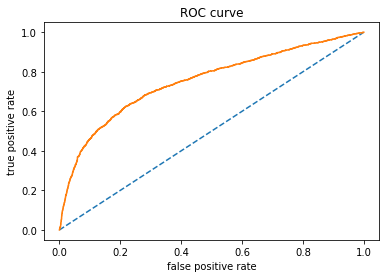

In [21]:
####### 
# 删XGB重要变量,不删'mrg_situ_cd', 'ovd_30d_loan_tot_cnt'
# new data
# tag: 丢'edu_deg_cd', 'deg_cd', 'atdd_type',
# ~跟\N都填充unknown
# job_year 填-1
#      合并四个交易的次数,
#      合并Car hou， ic fsind
#       加ovd_30d_loan_tot_cnt, his_lng_ovd_day组合
# 合并下载标志'dnl_mbl_bnk_ind', 'dnl_bind_cmb_lif_ind'
# 加风险等级的合并
# trx: 支付一级、二级最高次数代码，支出、收入、以及净收入（或净支出），总操作次数,各类代码
# 不加beh: 操作总次数、操作最高频页面代码,各类代码
################# XGBoost
xgb_cfl = xgb.XGBClassifier(n_jobs = -1,
                            n_estimators = 50,
                            class_weight = 'balanced',
                            max_depth = 3)

xgb_cfl.fit(trainx, trainy)
y_scorexgb = xgb_cfl.predict_proba(valx)[:,1]

rocxgb=roc_auc_score(valy, y_scorexgb)
print('roc ',rocxgb)
perfomance_clf(xgb_cfl, valx, valy)

plot_roc(valy, y_scorexgb)

roc  0.7539641241584953
accuracy score is: 0.8117720726361929
precision score is: 0.6638888888888889
recall score is: 0.2748706152961472
auc: 0.7539641241584953
- - - - - - 


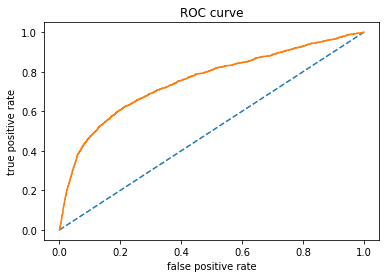

In [37]:
####### 
# 删XGB重要变量,不删'mrg_situ_cd', 'ovd_30d_loan_tot_cnt'
# new data
# tag: 丢'edu_deg_cd', 'deg_cd', 'atdd_type',
# ~跟\N都填充unknown
# job_year 填-1
#      合并四个交易的次数,
#      合并Car hou， ic fsind
#       加ovd_30d_loan_tot_cnt, his_lng_ovd_day组合
# 合并下载标志'dnl_mbl_bnk_ind', 'dnl_bind_cmb_lif_ind'
# 加风险等级的合并
# trx: 支付一级、二级最高次数代码，支出、收入、以及净收入（或净支出），总操作次数,各类代码
# 不加beh: 操作总次数、操作最高频页面代码,各类代码
################# XGBoost
xgb_cfl = xgb.XGBClassifier(n_jobs = -1,
                            n_estimators = 50,
                            class_weight = 'balanced',
                            max_depth = 3)

xgb_cfl.fit(trainx, trainy)
y_scorexgb = xgb_cfl.predict_proba(valx)[:,1]

rocxgb=roc_auc_score(valy, y_scorexgb)
print('roc ',rocxgb)
perfomance_clf(xgb_cfl, valx, valy)

plot_roc(valy, y_scorexgb)

roc  0.753749656824646
accuracy score is: 0.8116468378209142
precision score is: 0.6589986468200271
recall score is: 0.28004600345025876
auc: 0.753749656824646
- - - - - - 


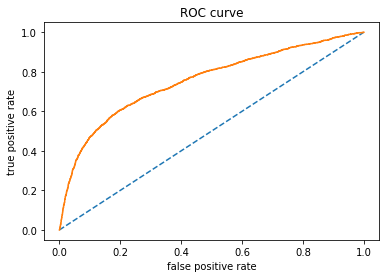

In [27]:
####### 
# 删XGB重要变量,不删'mrg_situ_cd', 'ovd_30d_loan_tot_cnt'
# new data
# tag: 丢'edu_deg_cd', 'deg_cd', 'atdd_type',
# ~跟\N都填充unknown
# job_year 填-1
#      合并四个交易的次数,
#      合并Car hou， ic fsind
#       加ovd_30d_loan_tot_cnt, his_lng_ovd_day组合
# 合并下载标志'dnl_mbl_bnk_ind', 'dnl_bind_cmb_lif_ind'
# 加风险等级的合并
# trx: 支付一级、二级最高次数代码，支出、收入、以及净收入（或净支出），总操作次数,各类代码
# 不加beh: 操作总次数、操作最高频页面代码,各类代码
################# XGBoost
xgb_cfl = xgb.XGBClassifier(n_jobs = -1,
                            n_estimators = 50,
                            class_weight = 'balanced',
                            max_depth = 3)

xgb_cfl.fit(trainx, trainy)
y_scorexgb = xgb_cfl.predict_proba(valx)[:,1]

rocxgb=roc_auc_score(valy, y_scorexgb)
print('roc ',rocxgb)
perfomance_clf(xgb_cfl, valx, valy)

plot_roc(valy, y_scorexgb)

In [40]:
train_x_array = np.array(train_DF_weneed.drop(['flag'], axis = 1)).astype(np.float32)
train_y_array = np.array(train_DF_weneed.flag).astype(np.float32)
colname = train_DF_weneed.drop(['flag'], axis = 1).columns.values.tolist()

In [41]:
from bess.linear import PdasLogistic
model = PdasLogistic(path_type = 'pgs', s_min = 1, s_max = len(colname), ic_type = 'ebic')
model.fit(train_x_array, train_y_array)
print(np.nonzero(model.beta))
print(model.beta[np.nonzero(model.beta)])

(array([ 0,  2,  3,  7,  8, 17, 19, 23, 27, 28, 29, 33, 39, 41, 42, 43, 47],
      dtype=int64),)
[ 3.19960980e-01 -8.17199872e-02  4.96488677e-02  2.74449264e-01
  4.11825143e-01 -1.29449883e-01  5.26144491e-02 -1.60342883e+00
 -1.50949984e-02 -3.66981717e-01  1.92898046e-01 -8.94447221e-05
  1.80174639e-01  1.25807771e-03  3.18190391e-01 -2.12920645e-03
 -7.10119905e-02]


In [42]:
selectCol = np.nonzero(model.beta)[0].tolist()
print(len(selectCol))

noSelectName = colname.copy()
selectName = [colname[i] for i in selectCol]

for sC in selectCol:
    noSelectName.remove(colname[sC])
    
print('No select')
print(len(noSelectName))
print(noSelectName)

print('\n Select: ')
print(len(selectName))
print(selectName)

17
No select
33
['age', 'job_year', 'ic_ind', 'fr_or_sh_ind', 'hav_car_grp_ind', 'hav_hou_grp_ind', 'l6mon_agn_ind', 'frs_agn_dt_cnt', 'vld_rsk_ases_ind', 'fin_rsk_ases_grd_cd', 'confirm_rsk_ases_lvl_typ_cd', 'cust_inv_rsk_endu_lvl_cd', 'tot_ast_lvl_cd', 'bk1_cur_year_mon_avg_agn_amt_cd', 'l12mon_buy_fin_mng_whl_tms', 'l12_mon_fnd_buy_whl_tms', 'l12_mon_gld_buy_whl_tms', 'loan_act_ind', 'pl_crd_lmt_cd', 'perm_crd_lmt_cd', 'cur_debit_cnt', 'cur_credit_cnt', 'cur_credit_min_opn_dt_cnt', 'cur_debit_crd_lvl', 'I12_mon_whl_tms', 'cur_debit_card', 'cur_credit_card', 'hav_car_hou_ind', 'cny_trx_income', 'cny_trx_pay', 'actual_income', 'most_tms_page_no', 'total_page_no_tms']

 Select: 
17
['gdr_cd', 'mrg_situ_cd', 'acdm_deg_cd', 'dnl_mbl_bnk_ind', 'dnl_bind_cmb_lif_ind', 'l6mon_daim_aum_cd', 'pot_ast_lvl_cd', 'l12_mon_insu_buy_whl_tms', 'hld_crd_card_grd_cd', 'crd_card_act_ind', 'l1y_crd_card_csm_amt_dlm_cd', 'cur_debit_min_opn_dt_cnt', 'ic_fr_sh_ind', 'ovd_cnt', 'most_Trx_Cod1_Cd', 'most_Trx

In [ ]:
# 从数据初探可以发现，'未来两年可能违约'标签类别分布不均，需对样本进行重取样
def resample(df):
    '''
    使样本'未来两年可能违约'标签的0，1项可以各占一半，以提高预测效果。sample()可以考虑添加random_state以便生成相同样本集
    df：数据源
    '''
    num = df['flag'].value_counts()[1]
    df_t = df[df.flag == 1]
    df_f = df[df.flag == 0].sample(frac=1)[0:num]
    df_balanced = pd.concat([df_t,df_f]).sample(frac=1).reset_index(drop=True)
#     print(df_balanced.未来两年可能违约.value_counts())
    return df_balanced

df_balanced = resample(train_DF_weneed)
df_balanced['flag'].value_counts()